## What Time Series Analysis Actually Is

Time Series Analysis (TSA) is the process of analysing data points collected at regular time intervals to uncover meaningful patterns, behaviours, and structure that can help us understand the past and forecast the future.

At its core, TSA assumes that the past contains useful information about the future. In practice, this means each new observation is, to some degree, autocorrelated with previous observations — today's value is not independent of yesterday's value.

This idea of temporal dependence (how far back past observations continue to influence the present) is what underpins modern forecasting techniques and has driven much of the innovation we see today across data science, econometrics, and machine learning.


### The End-to-End Time Series Workflow

To keep all of the pieces in context, here is the high-level loop we are following throughout this notebook:

1. **Raw Time Series → Cleaning & EDA**
2. **Check Stationarity** (visuals + tests)
3. **Target Transformations** (log, diff, returns, etc.)
4. **Feature Engineering**
   - Endogenous (lags, rolling stats, technical indicators)
   - Exogenous (market indices, macro, holidays, etc.)
5. **Model Selection & Training**
   - Baselines (naïve, seasonal naïve)
   - Classical models (ARIMA families, ETS, etc. if available)
   - ML/AutoML models (e.g. AutoGluon)
6. **Backtesting & Evaluation**
   - Rolling / expanding windows
   - Multiple metrics (e.g. MAPE / sMAPE / MASE / RMSE)
7. **Forecasting & Interpretation**
   - Compare models
   - Sanity-check forecasts
   - Feed back into feature and model choices


> 🧠 **Mental model:** Every section you read fits somewhere in this loop. When in doubt, ask: *“Which step am I in?”* and *“What’s the very next step in this flow?”*.


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings(action="ignore")

## Stationarity

Before we can understand any underlying patterns in a time series, we need to extract its temporal features and analyse how they behave over time. But here’s the catch: most statistical techniques assume that the target variable (‘y’) is statistically consistent throughout the dataset. In other words, if you take any random sample of the series, it should have roughly the same mean and standard deviation as the entire dataset. This property is known as **stationarity**.

In traditional classification or regression tasks, we often assume this is true by default. But in time-series, this assumption almost never holds. By definition, the data is influenced by time itself, and therefore shaped by evolving forces such as trends, seasonality, structural breaks, regime shifts, and external events.

📌 **At a glance**

- A time series is (weakly) stationary if its **mean, variance, and autocorrelation structure are stable over time**.
- Most classical forecasting methods (ARIMA-family, many statistical tests) *assume* stationarity of the **target**.
- In practice you rarely get perfect stationarity — you diagnose the main non-stationarities (trend/seasonality/variance)
  and stabilise them with **transformations (log)** and **differencing/returns** before modelling.
- Your goal is *not* to make the world stationary — just to make the **residuals** from your model behave like white noise.


## Target Transformation
Because the statistical behaviour of the series changes over time, **raw time-series data is usually non-stationary**, and one of our early responsibilities is to diagnose and address that before applying most forecasting models.

To achieve this, we apply transformations to the target to coerce stationarity. The right choice depends entirely on the behaviour of the original series. For example:
- A log transformation helps stabilise variance when values grow exponentially or span large scales.
- Differencing (first or second difference) removes trend and makes the series more mean-constant over time.

In practice, most real-world series become stationary after a log transform followed by one or two rounds of differencing — but the exact approach depends on what the underlying data is doing.

📌 **At a glance**

- Use **log** when variance increases with the level of the series (bigger values swing more).
- Use **differences / log-differences** when the mean drifts over time (trend or random walk behaviour).
- Use **returns** when the interpretation of *percentage change* is more meaningful than raw level differences.
- Always visually inspect: raw vs transformed series, and run your **stationarity tests on the transformed target**, not the raw one.


### Transformation Table

Below is a practical table to help identify which target transformation to use. Each option highlights why you’d use it, what it fixes, and the scenarios where it genuinely makes sense. Use this table as your quick decision guide before running stationarity tests or building a forecasting model.

| Transformation                 | Goal / Fixes                                             | **Stationarity Effect (Stars + Description)**                       | Best Scenario (Examples)                                                                                                                        | Pandas / NumPy Code                                               | Requirements / Restrictions    | Output Characteristics                       | Best TS Models                                                | Key Assumptions                                           |
| ------------------------------ | -------------------------------------------------------- | ------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------- | ------------------------------ | -------------------------------------------- | ------------------------------------------------------------- | --------------------------------------------------------- |
| **Raw (no transform)**         | Preserve original scale                                  | ⭐ — Does not remove trend or variance instability                   | Stable processes, stationary sensor data, residual series, control systems                                                                      | `df["y"]`                                                         | None                           | Original distribution unchanged              | NaiveModel, AverageModel, ETSModel, TFTModel, ChronosModel    | Assumes underlying data is already stable or detrended    |
| **Log Transform**              | Stabilises variance; reduces right-skew                  | ⭐⭐ — Moderately stabilises variance; does not remove trend          | Positive-only data: sales volume, web traffic, financial metrics, insurance claims                                                              | `np.log(df["y"])` (y > 0)<br>`np.log1p(df["y"])` (safe for zeros) | y > 0 for log; y ≥ 0 for log1p | Reduces skew; compresses spikes              | DeepARModel, PatchTSTModel, ETSModel                          | Assumes multiplicative variance; trend remains            |
| **First Difference (diff1)**   | Removes linear trend                                     | ⭐⭐⭐⭐ — Strong trend removal; variance unchanged                     | Trending prices, inflation series, macro indicators (GDP, CPI), retail demand                                                                   | `df["y"].diff()`                                                  | Requires ≥2 points             | Removes drift; may increase short-term noise | AutoARIMAModel, DLinearModel                                  | Assumes trend removable via differencing                  |
| **Second Difference (diff2)**  | Removes nonlinear / curved trend                         | ⭐⭐⭐⭐⭐ — Removes nonlinear trend; strongest detrending               | **Uncommon.** Strongly accelerating or decelerating macro indicators (population growth, long-horizon inflation, slow-moving structural demand) | `df["y"].diff().diff()`                                           | Requires long history          | Strong detrending; amplified noise           | AutoARIMAModel (higher d), DLinearModel                       | Assumes second-order structure; risk of over-differencing |
| **Log-Difference (logdiff1)**  | Removes trend + stabilises variance (log-returns)        | ⭐⭐⭐⭐⭐ — Excellent for financial series; trend + variance stabilised | Stock prices, FX, ETFs, commodities, crypto                                                                                                     | `np.log(df["y"]).diff()`                                          | y > 0                          | Approx. normal returns; stable variance      | AutoARIMAModel, DeepARModel, PatchTSTModel, TFT, ChronosModel | Assumes multiplicative structure (finance)                |
| **Percent Change (returns)**   | Converts to growth rates                                 | ⭐⭐⭐⭐ — Removes level trend; stabilises relative growth              | Web traffic growth, marketing KPIs, macro %-change processes                                                                                    | `df["y"].pct_change()`                                            | y > 0                          | Relative % change; volatile near zero        | ARIMA, ML-based models                                        | Assumes denominator not near zero                         |
| **Rolling Z-Score**            | Local mean + variance normalization                      | ⭐⭐⭐ — Stabilises local variance; handles regime shifts              | **Uncommon.** Regime-shifting markets (VIX, crypto), drifting sensor data, structural state changes                                             | `(df["y"] - y.rolling(20).mean()) / y.rolling(20).std()`          | Rolling window ≥20             | Locally normalised; adapts to regime shifts  | TFTModel, PatchTSTModel, DeepARModel                          | Assumes meaningful local window                           |
| **Min-Max Scaling**            | Normalise to [0,1] range                                 | ⭐ — No stationarity improvement                                     | Energy load forecasting, IoT sensors, multivariate neural networks                                                                              | `(y - y.min()) / (y.max() - y.min())`                             | Needs global min/max           | Strict 0–1 scale                             | Transformers, Neural Nets                                     | Assumes future values lie within observed range           |
| **Standard Scaling (Z-score)** | Stabilise feature scales                                 | ⭐ — Does not remove trend or seasonality                            | Multivariate ML/DL tasks (telemetry, retail covariates, macro features)                                                                         | `(y - y.mean()) / y.std()`                                        | None                           | Centred + normalised distribution            | DeepAR, PatchTST, Tabular models                              | Assumes normalization improves model training             |
| **Box-Cox Transform**          | Variance stabilisation + improved normality              | ⭐⭐⭐ — Moderately stabilises variance; normalises distribution       | Skewed positive-only data: rainfall, insurance claims, call centres                                                                             | `stats.boxcox(y)`                                                 | y > 0                          | Less skew; more Gaussian                     | ETSModel, ML models                                           | Assumes valid λ parameter exists                          |
| **Yeo-Johnson Transform**      | Variance stabilisation across positive + negative values | ⭐⭐⭐ — Moderately stabilises variance; works even when y < 0         | Mixed-sign KPIs, behavioural metrics, ratios                                                                                                    | `PowerTransformer("yeo-johnson")`                                 | None                           | Reduced skew; smoother distribution          | ML models, Tabular models                                     | Assumes power transform appropriate                       |


## TSA Features

📌 **At a glance**

- **Endogenous features** come from the target itself (lags, rolling stats, technical indicators).
- **Exogenous features** are external drivers (indices, macro, holidays, events, other assets).
- **Static features** describe the entity (item metadata), while **dynamic features** change over time.
- Good time-series feature engineering = capturing *plausible causal drivers* without leaking information from the future.


### Target-derived Features i.e. Endogenous

Many traditional TSA methods focus on univariate analysis — meaning they only model the target variable itself. In these cases, the model relies entirely on endogenous features, which are **features derived internally from the target**. 

For example, if the target is price, then only features that can be derived from price is endogenous.

These features depend entirely on past values (see "Past Features" in next section) e.g. 
- date/time components
- rolling averages
- moving momentums
- lagged values
- seasonal decompositions
- trend indicators

Models/methods that support only endogenous features include:
- AR
- MA
- ARMA
- ARIMA, SARIMA
- ETS



### External Features i.e. Exogenous

However, in real life, the target variable is often influenced by exogenous features — external factors generated outside the target series. These are independent variables that help explain or predict movement in the target. 

Examples include:
- macro: inflation rates, interest rates
- market forces: commodity prices, competitor campaigns
- company: marketing spend/budget
- temporal: Public Holidays, month, quarter, year



Models/methods that support exogenous features include:
- ARIMAX
- SARIMAX
- VAR / VARMAX
- DeepAR
- PatchTST
- TFT
- Chronos models

### Model Training: Static v. Dynamic Features
In model training, Endogenous v. Exogenous Features are typically classified under:
1. Static
2. Dynamic
   1. Future / Known Features
   2. Past Features

#### Static Features i.e. Fixed exogenous
Static Features are exogenous features that are fixed for the entire time-series and not derived from the target e.g. (store_id, product_id, region, category). 
Q. For models that support exogenous features, do they need to be encoded? 


#### Future / Known Features i.e. Dynamic exogenous
Future / Known Features are exogenous features where we know their past values and future values in our forecast horizon e.g. day of the week, month, public holidays, weekends, publicly announced events (US Fed Meetings) etc.

#### Past Features
Past Features are features where we only know their past values and can be either Endogenous or Exogenous.

Endogenous past features (derived from target)
- rolling averages of price
- lagged returns
- momentum metrics
- diff/logdiff of the target

Exogenous past features (external series)
- past temperatures
- past volumes (when target is price)
- past rainfall
- past CPI
- past sensor readings

**Reminder: Univariate models can only use past endogenous features**

## Model Selection

TS Forecasting models can be divided into three broad categories: local (Statistical), global (Deep Learning and Tree-based), and a combo of models (Ensemble)

**Statistical** are simple statistical models that are specifically designed to capture patterns such as trend or seasonality.
Despite their simplicity, these models often produce reasonable forecasts and serve as a strong baseline.
Some examples of available local models:

- `ETS`
- `AutoARIMA`
- `Theta`
- `SeasonalNaive`

**Deep Learning Models - out of scope** are neural-network algorithms commonly found in PyTorch, such as:

- `DeepAR`
- `PatchTST`
- `DLinear`
- `TemporalFusionTransformer`

This category also includes pre-trained LLMs like `Chronos`

**Tree-based - out of scope**
Models that convert the forecasting task into a regression problem and fit models such as:
- `LightGBM` 
- `RecursiveTabular`
- `DirectTabular`.




| Model Name                         | Best Use Case / Scenario                                     | Architecture                        | Best Eval Metric     | Performance Rating | Compute Rating | Data Requirements                                               |
| ---------------------------------- | ------------------------------------------------------------ | ----------------------------------- | -------------------- | ------------------ | -------------- | --------------------------------------------------------------- |
| **NaiveModel**                     | Quick baseline; stable or flat series                        | Simple Heuristic                    | MAPE / MAE           | ⭐                  | ⭐⭐⭐⭐⭐          | **Endogenous Features —** no external inputs needed             |
| **SeasonalNaiveModel**             | Strong stable seasonality (weekly/annual retail cycles)      | Simple Heuristic                    | sMAPE / MAPE         | ⭐⭐                 | ⭐⭐⭐⭐⭐          | **Endogenous Features —** requires seasonal pattern             |
| **AverageModel**                   | Stationary or slow-moving series                             | Simple Average                      | MAE / RMSE           | ⭐                  | ⭐⭐⭐⭐⭐          | **Endogenous Features —** stationary or detrended series        |
| **ETSModel**                       | Short-term retail demand; clean seasonal patterns            | State Space (Exponential Smoothing) | MAPE / AIC           | ⭐⭐⭐                | ⭐⭐⭐⭐           | **Endogenous Features —** handles trend/seasonality             |
| **AutoARIMAModel**                 | Economic indicators; financial TS; medium-length sequences   | Box–Jenkins ARIMA                   | AIC / BIC / RMSE     | ⭐⭐⭐⭐               | ⭐⭐⭐            | **Endogenous Features —** stationarity (auto-diff applied)      |
| **AutoETSModel**                   | Automated exponential smoothing across many series           | State Space                         | MAPE / AIC           | ⭐⭐⭐                | ⭐⭐⭐            | **Endogenous Features —** automatic trend/seasonality selection |
| **ThetaModel**                     | Competition benchmarks; simple smooth trends                 | Statistical Decomposition           | sMAPE / MASE         | ⭐⭐⭐                | ⭐⭐⭐⭐           | **Endogenous Features —** decomposition of target only          |
| **NPTSModel**                      | Non-linear patterns; smoothing over local structure          | Kernel / Local Regression           | RMSE / MAE           | ⭐⭐⭐                | ⭐⭐⭐            | Sufficient historical data                                      |
| **DeepARModel**                    | Many related series; probabilistic forecasting               | RNN (LSTM)                          | CRPS / Quantile Loss | ⭐⭐⭐⭐               | ⭐⭐             | Large dataset + covariates                                      |
| **DLinearModel**                   | Long sequences; trend-dominated data                         | Feedforward Neural Net              | MSE / MAE            | ⭐⭐⭐                | ⭐⭐⭐            | Detrending helpful                                              |
| **PatchTSTModel**                  | Long-range dependencies; multivariate TS with covariates     | Transformer                         | MSE / MAE            | ⭐⭐⭐⭐               | ⭐⭐             | Long sequences preferred                                        |
| **TemporalFusionTransformerModel** | Multi-horizon forecasting; rich covariates; interpretability | Hybrid LSTM + Transformer           | Quantile Loss / CRPS | ⭐⭐⭐⭐⭐              | ⭐              | Rich dynamic/static features                                    |
| **TiDEModel**                      | Long-term dependencies; efficient covariate use              | Dense Feedforward Encoder           | MSE / MAE            | ⭐⭐⭐⭐               | ⭐⭐             | Covariate information helpful                                   |
| **WaveNetModel**                   | High-frequency patterns (audio-like, sensors, ticks)         | Dilated CNN                         | Quantile Loss / MSE  | ⭐⭐⭐⭐               | ⭐⭐             | High-frequency signal required                                  |
| **DirectTabularModel**             | Feature-engineered forecasting; interpretable ML             | Tree/Linear Models                  | RMSE / R²            | ⭐⭐⭐                | ⭐⭐⭐            | Tabular features                                                |
| **RecursiveTabularModel**          | Autoregressive ML; per-step interpretability                 | Tree/Linear Models                  | RMSE / MAE           | ⭐⭐⭐                | ⭐⭐             | Tabular features                                                |
| **ChronosModel**                   | Zero-shot / limited data; pretrained foundation TS model     | Transformer (Pretrained)            | MAPE / CRPS          | ⭐⭐⭐⭐⭐              | ⭐⭐             | -                                                               |

📌 **At a glance**

- Always benchmark against **simple baselines** (naïve, seasonal naïve, mean) before trusting complex models.
- Choose models based on:
  - **data shape** (length, frequency, number of series),
  - **signal complexity** (trend/seasonality/non-linearity),
  - **operational constraints** (speed, interpretability, deployment).
- Use **multiple metrics** and **rolling backtests** rather than a single train/validation split.
- If a fancy model only beats a simple baseline by a tiny margin, prefer the simpler model.


Let's create a real use case (stock price analysis) for TS analysis and analyse the impact of two different approaches i.e. we'll train both endogenous only and exogenous models.

Let's get started with the ts dataset and create a us_stock_market_data function that uses Yahoo Finance to extract 3 years of stock prices and volumes

We'll create two different time-series datasets: one called endo_ts and the other exo_ts:
- endo_ds = closing prices of the stock over the time-series
- exo_ds = closing prices of the stock + volume of the stock + market performance over the time-series

Note: we'll select Tesla as the stock - as we're using Tesla, we're going to classify it as a "tech" stock (rightly or wrongly!) and pull data from the Invesco Trust ETF that mimics the Nasdaq's performance.


In [2]:
def us_stock_market_data(ticker, start, end, interval):

    df_raw = yf.download(ticker, start=start, end=end, interval=interval)

    if isinstance(df_raw.columns, pd.MultiIndex):
        df_raw.columns = [col[0] for col in df_raw.columns]

    df_raw = df_raw.reset_index()

    df_raw['Date'] = pd.to_datetime(df_raw['Date'])

    return df_raw

df_tsla = us_stock_market_data("TSLA", "2021-07-01", "2025-06-30", "1d")
df_nasdaq = us_stock_market_data("QQQ", "2021-07-01", "2025-06-30", "1d")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df_tsla.head(3)

,Date,Close,High,Low,Open,Volume
0,2021-07-01,225.973328,229.330002,224.266663,227.973328,55903500
1,2021-07-02,226.300003,233.333328,224.419998,226.326660,81163500
2,2021-07-06,219.860001,228.000000,217.133331,227.236664,69853500


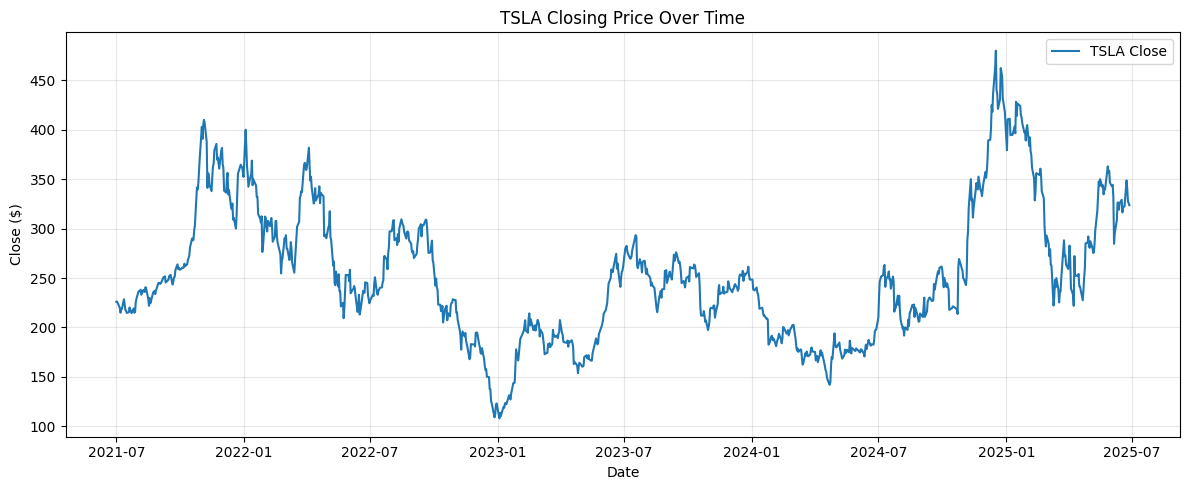

In [4]:
endo_ds = df_tsla[['Date', 'Close']]

plt.figure(figsize=(12,5))
plt.plot(endo_ds['Date'], endo_ds['Close'], label="TSLA Close")
plt.title("TSLA Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close ($)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



#### Target Transformation: Log-Difference (logdiff1)
This is the standard transformation for financial series

In [5]:
endo_ds['target'] = np.log(endo_ds['Close']).diff()

Log returns are preferred because they remove the trend, stabilize the variance, produce an approximately stationary series, and yield a distribution well-behaved *enough* for most forecasting models.

We can take a look at the others too:

In [7]:
from statsmodels.tsa.stattools import acf


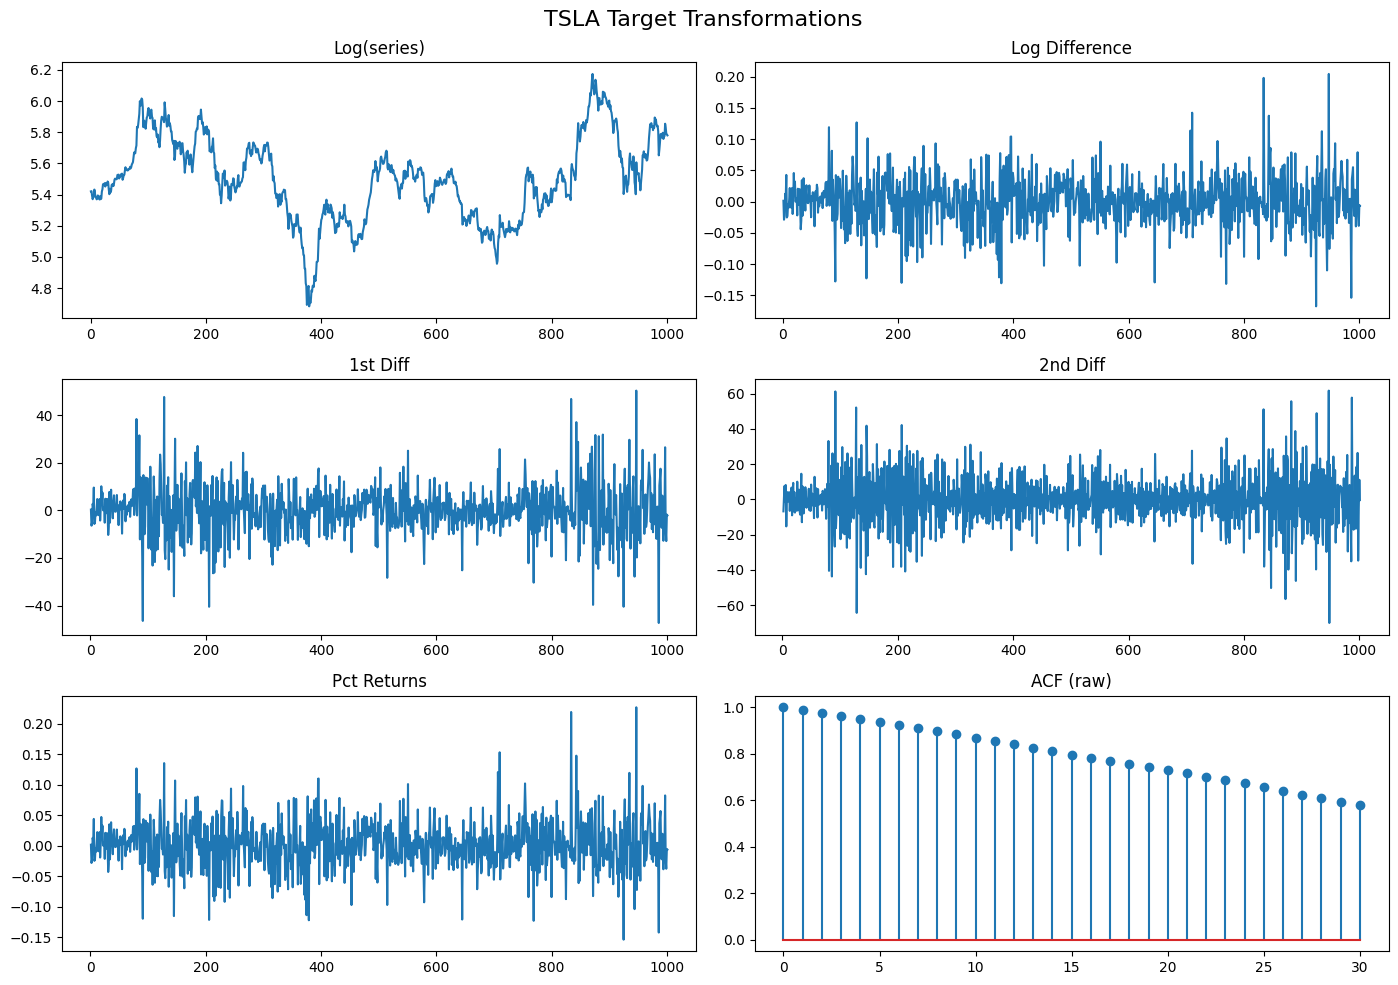

In [8]:
ts = endo_ds['Close']

# --- PLOT ---
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

# log
np.log(ts).plot(ax=axes[0], title="Log(series)")

# log diff
np.log(ts).diff().plot(ax=axes[1], title="Log Difference")

# diff
ts.diff().plot(ax=axes[2], title="1st Diff")

# 2nd diff
ts.diff().diff().plot(ax=axes[3], title="2nd Diff")

# return pct
ts.pct_change().plot(ax=axes[4], title="Pct Returns")

# 6 ACF
acf_vals = acf(ts.dropna(), fft=False, nlags=30)
axes[5].stem(acf_vals)
axes[5].set_title("ACF (raw)")

plt.suptitle("TSLA Target Transformations", fontsize=16)
plt.tight_layout()
plt.show()

ACF plot shows:
- Today (lag 1) is very similar to yesterday
- There's a weekly pattern (high bar at lag 7)
- There's a relatively strong trend in the short

So, do we get stationarity with log difference? Let's test:

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationary_stats(df, cols, p_thresh=0.05):
    out = []
    for c in cols:
        series = df[c].dropna()
        adf_p = adfuller(series)[1]
        kpss_p = kpss(series, nlags="auto")[1]
        out.append({
            "column_name": c,
            "adf_p": adf_p,
            "kpss_p": kpss_p,
            "adf_test": "Pass" if adf_p < p_thresh else "Fail",
            "kpss_test": "Pass" if kpss_p > p_thresh else "Fail"
        })
    return pd.DataFrame(out)

stationary_stats = stationary_stats(endo_ds, ['target', 'Close'])
stationary_stats.head()

,column_name,adf_p,kpss_p,adf_test,kpss_test
0,target,0.000000,0.100000,Pass,Pass
1,Close,0.090653,0.032463,Fail,Fail


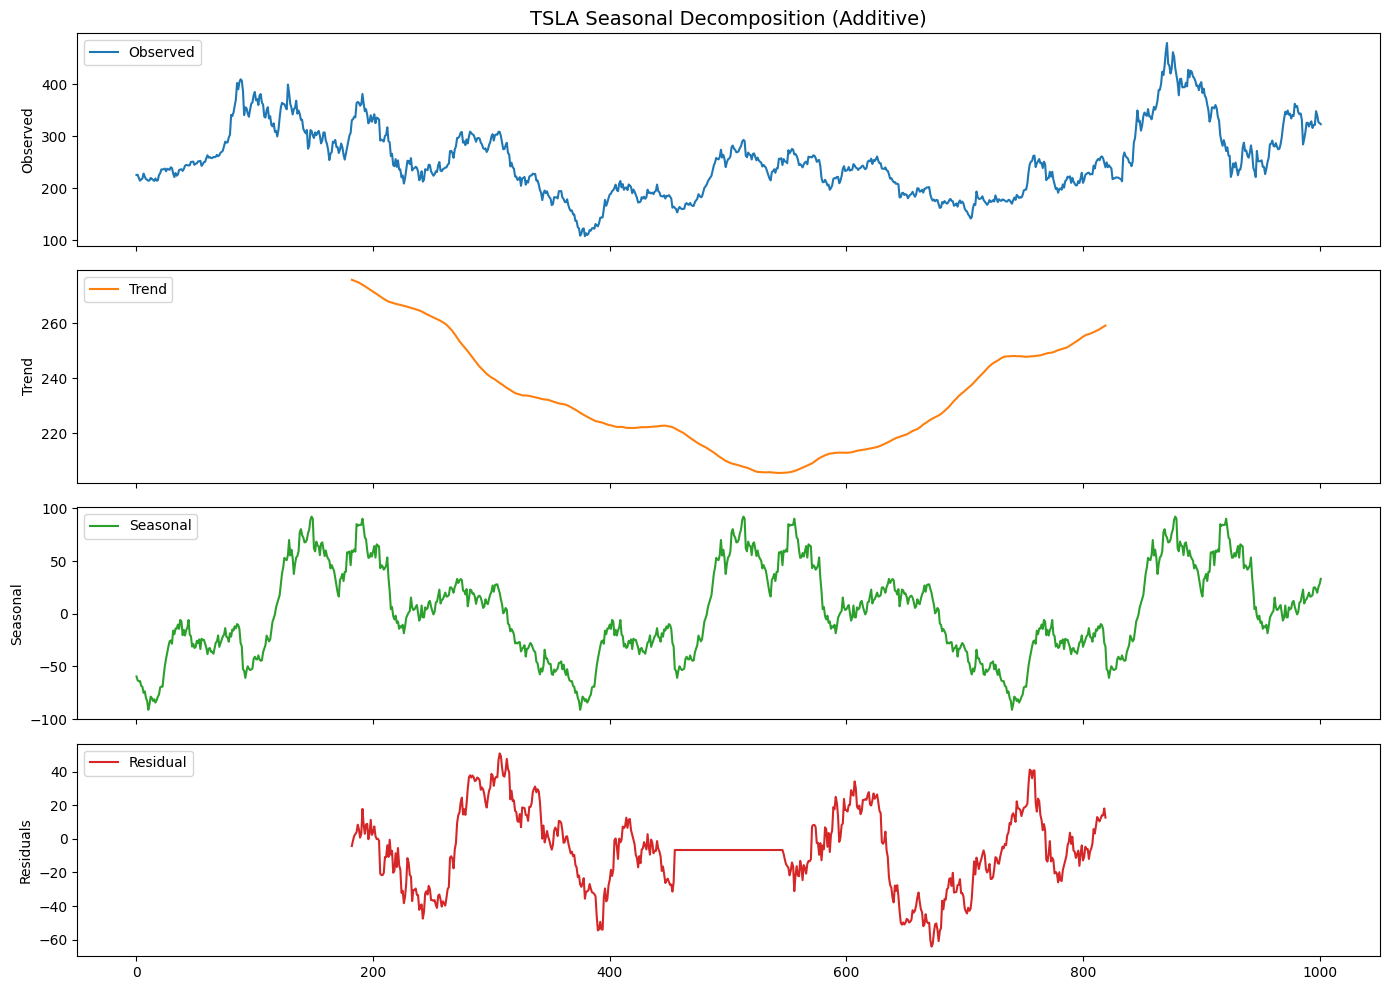

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = endo_ds['Close'].dropna()

result = seasonal_decompose(ts, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Observed
axes[0].plot(result.observed, label="Observed", color="C0")
axes[0].set_ylabel("Observed")
axes[0].legend(loc="upper left")
axes[0].set_title("TSLA Seasonal Decomposition (Additive)", fontsize=14)

# Trend
axes[1].plot(result.trend, label="Trend", color="C1")
axes[1].set_ylabel("Trend")
axes[1].legend(loc="upper left")

# Seasonal
axes[2].plot(result.seasonal, label="Seasonal", color="C2")
axes[2].set_ylabel("Seasonal")
axes[2].legend(loc="upper left")

# Residual
axes[3].plot(result.resid, label="Residual", color="C3")
axes[3].set_ylabel("Residuals")
axes[3].legend(loc="upper left")

plt.tight_layout()
plt.show()



TS data appears driven primarily by non-stationary trend components and high-frequency noise rather than stable seasonal cycles

Or more generally:
1. A strong trend
- Prices wander and create long-term up/down movements.
- This trend is not consistent and changes slope over time.

2. Very weak or artificial seasonality
- Daily financial time series rarely have strong deterministic seasonal cycles.

3. Heavy, noisy, volatile residuals
- Contains volatility clustering
- Contains short-term shocks
- Represents market randomness + event-driven noise

In [13]:
endo_ds = endo_ds.drop(columns="Close", errors="ignore")

In [14]:
def endo_features(df, target):
    df[target + "_r1"] = df[target].pct_change(1)
    df[target + "_r7"] = df[target].pct_change(7)
    df[target + "_r14"] = df[target].pct_change(14)

    df[target + "_ma5"] = df[target].rolling(5).mean()
    df[target + "_ma10"] = df[target].rolling(10).mean()
    df[target + "_ma20"] = df[target].rolling(20).mean()

    delta = df[target].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df[target + "_rsi14"] = 100 - (100 / (1 + rs))

    return df

endo_ds = endo_features(endo_ds, 'target')

####  AutoGluon

We're going to use AutoGluon for model training for several reasons, namely:

**Convenience:**
AutoGluon abstracts away the heavy lifting — model selection, hyperparameter tuning, validation strategy, and ensembling. Instead of manually training ARIMA, ETS, DeepAR, PatchTST, etc., AutoGluon does this automatically and consistently.

**Endo & Exo Models:**
AutoGluon seamlessly handles both endogenous (lags, rolling features, target-derived signals) and exogenous features (weather, macro data, holidays, volume, engineered covariates). This allows us to build richer forecasting pipelines without manually wiring multiple model families together.

**AWS Support:**
AutoGluon has first-class integration with AWS services, especially SageMaker, making it easy to scale forecasting experiments, run distributed jobs, deploy models as endpoints, and fit seamlessly into your existing company's production workflow.

In [15]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

#### Model Data: Autogluon naming convention

In [16]:
def autogluon_prep(df, item_col, dt_col, target_col):
    if item_col is None:
        item_val = input("Provide item_id value: ")
        df["item_id"] = item_val
    else:
        df = df.rename(columns={item_col: "item_id"})
        
    df = df.rename(columns={dt_col: "timestamp", target_col: "target"})
    
    others = [c for c in df.columns if c not in ["item_id", "timestamp", "target"]]
    resp = input(f"Confirm Past Features (Y/N): {others} ")

    if resp.strip().upper() == "Y":
        return df
    
    drop_cols = input("Provide list of drop columns: ").split(",")
    drop_cols = [c.strip() for c in drop_cols]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    return df


In [17]:
endo_ts = autogluon_prep(df=endo_ds, item_col=None, dt_col="Date", target_col="target")

#### Model Data: Train, test split

In time-series forecasting, we **never use a random train/test split** because it breaks the temporal structure. Instead, we split the dataset chronologically, preserving the true order of events.

When forecasting a fixed horizon — say 14 days (prediction length) — the rule is simple:
- Train ds = all target and all features before the final 14 observations (based on timestamp)
- Test ds = the last 14 observations (based on timestamp)

This ensures that:
a. the model only learns from the past,
b. evaluation is fair (no leakage), and
c. the test set is a true simulation of “future” timestamps.

Note: eval ds is automatically pulled from train_ds by Autogluon

In [18]:
prediction_length = 14
endo_ts_ds = TimeSeriesDataFrame.from_data_frame(
    endo_ts,
    id_column="item_id",
    timestamp_column="timestamp",
)

endo_train_ds, endo_test_ds = endo_ts_ds.train_test_split(prediction_length)

#### Model Selection

In [19]:
ts_models = ['ADIDA', 'ARIMA', 'AutoARIMA', 'AutoCES', 'AutoETS', 'Average', 'Chronos', 'Croston', 'CrostonSBA', 'DLinear', 'DeepAR', 'DirectTabular', 'DynamicOptimizedTheta', 'ETS', 'IMAPA', 'NPTS', 'Naive', 'PatchTST', 'PerStepTabular', 'RecursiveTabular', 'SeasonalAverage', 'SeasonalNaive', 'SimpleFeedForward', 'TemporalFusionTransformer', 'Theta', 'TiDE', 'WaveNet', 'Zero']

endo_models = ['Theta', 'ETS', 'Naive']
ignore_models = [model for model in ts_models if model not in endo_models]

#### Model Training

FYI - for more info on observed issues with Autogluon, see last section

Predictor Params (select):
1. num_val_windows=3 inside predictor.fit() performs internal backtesting for model selection, not for final model evaluation. Creates 3 separate backtest windows, where the forecast horizon start at multiple points back in time. This evaluates the model under different historical conditions. AutoGluon internally decides where the windows go based on train_ds.
2. freq="D" # to indicate that the filled index must have a daily frequency - AutoGluon will automatically convert any data into daily frequency and deal with missing values.
3. eval_metric = "MAPE" Human-readable: “on average, we’re off by X%" Works for both statistical and deep models

In [20]:
endo_predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    #known_covariates_names=known_covariates, select exo models only
    freq="D",
    eval_metric="MAPE",
)

Fit Params (select):
1. presets = fast_training is the fastest but lowest quality and I believe is only for endogenous models
2. time_limit = constrain the predictor to generate a response within a set timeframe
3. num_val_windows=3 inside predictor.fit() performs internal backtesting for model selection, not for final model evaluation. Creates 3 separate backtest windows, where the forecast horizon start at multiple points back in time. This evaluates the model under different historical conditions. AutoGluon internally decides where the windows go based on train_ds.
4. excluded_model_types = in addition to presets having an implicit impact on what models will be selected, you can explicitly exclude models and save on computation time

In [21]:
endo_predictor.fit(
    endo_train_ds,
    presets="medium_quality", #"fast_training"
    time_limit=240,
    num_val_windows=3,
    random_seed=42,
    excluded_model_types = ignore_models,

)

Beginning AutoGluon training... Time limit = 240s
AutoGluon will save models to '/Users/tobygardner/Projects/uc-berkeley-aiml-course/notebooks/AutogluonModels/ag-20251118_053122'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:30:55 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6031
CPU Count:          32
GPU Count:          1
Memory Avail:       483.63 GB / 512.00 GB (94.5%)
Disk Space Avail:   1375.91 GB / 1858.19 GB (74.0%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['ADIDA',
                          'ARIMA',
                          'AutoARIMA',
                          'AutoCES',
                          'AutoETS',
                          'Average',
                          'Chronos',
                          

#### Model Evals: backtesting

Backtesting evaluates the selected model over multiple historical forecast horizons.

Tip: num_val_windows and prediction_length from predictor.fit should not be the same in predictor.evaluate - you generally want your final evaluation to test different windows to training.

This ensures:

✔️ Evaluation windows sit inside the test set,
✔️ They do not overlap with training windows,
✔️ You get clean and honest backtesting.

In [22]:
endo_predictor.leaderboard(silent = True)

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.179859,1.220605,0.086534,4
1,ETS,-1.200131,1.194374,1.621671,2
2,Theta,-1.304741,0.026231,1.248509,3
3,Naive,-4.690551,0.844888,1.715191,1


In [23]:
num_val_windows = 3
backtest_scores = []

for offset in range(-num_val_windows * prediction_length, 0, prediction_length):
    score = endo_predictor.evaluate(endo_test_ds, cutoff=offset)
    mape = round(score["MAPE"], 2)
    backtest_scores.append({
        "forecast_horiz_days": abs(offset),
        "MAPE": mape
    })

# Convert to DataFrame for easy calculations
backtest_df = pd.DataFrame(backtest_scores)

# Extract model name
endo_model = endo_predictor.leaderboard(silent=True).loc[0, "model"]

# Compute mean MAPE across all backtest windows
avg_mape = backtest_df["MAPE"].mean()

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [24]:
# Final summary print
print(f"On average, our Endogenous {endo_model} model is off by {abs(avg_mape):.2f}%.")

On average, our Endogenous WeightedEnsemble model is off by 1.92%.


### Exo comparison

In [25]:
# Past Features - Exogenous (Volume, Nasdaq price)
nasdaq_ds = df_nasdaq[['Date', 'Close']]
exo_ds = df_tsla[['Date', 'Close', 'Volume']]
exo_ds = exo_ds.merge(nasdaq_ds, on="Date", how="outer")
exo_ds.head()

,Date,Close_x,Volume,Close_y
0,2021-07-01,225.973328,55903500,345.363342
1,2021-07-02,226.300003,81163500,349.327606
2,2021-07-06,219.860001,69853500,350.837372
3,2021-07-07,214.883331,56376000,351.577698
4,2021-07-08,217.603333,68319900,349.454254


In [26]:
exo_ds['target'] = np.log(exo_ds['Close_x']).diff()
exo_ds['nasdaq'] = np.log(exo_ds['Close_y']).diff()
exo_ds['vol'] = np.log1p(exo_ds['Volume'])

exo_ds = exo_ds.drop(columns=["Close_x", "Close_y", "Volume"], errors="ignore")

exo_ds = endo_features(exo_ds, 'target')

In [27]:
# Future / Known Features - Exogenous 
exo_ds['feat_f_weekday'] = exo_ds['Date'].dt.dayofweek
exo_ds['feat_f_month'] = exo_ds['Date'].dt.month
exo_ds['feat_f_year'] = exo_ds['Date'].dt.year
exo_ds['feat_f_dow_sin'] = np.sin(2 * np.pi * exo_ds['feat_f_weekday'] / 7)
exo_ds['feat_f_dow_cos'] = np.cos(2 * np.pi * exo_ds['feat_f_weekday'] / 7)

known_covariates = [col for col in exo_ds.columns if col.startswith('feat_f_')]

In [28]:
exo_ts = autogluon_prep(df=exo_ds, item_col=None, dt_col="Date", target_col="target")

exo_ts_ds = TimeSeriesDataFrame.from_data_frame(
    exo_ts,
    id_column="item_id",
    timestamp_column="timestamp",
)

exo_train_ds, exo_test_ds = exo_ts_ds.train_test_split(prediction_length)

In [29]:
exo_models = ['DeepAR', 'Chronos', 'SimpleFeedForward']
ignore_other_models = [model for model in ts_models if model not in exo_models]

In [79]:
exo_predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    known_covariates_names=known_covariates,
    freq="D",
    eval_metric="MAPE",
)


exo_predictor.fit(
    exo_train_ds,
    hyperparameters={
        "Chronos": {},
        "DeepAR": {},
    },
    presets="medium_quality", #"fast_training"
    time_limit=800,
    num_val_windows=3,
    random_seed=42,
    excluded_model_types = ignore_other_models,

)

Beginning AutoGluon training... Time limit = 800s
AutoGluon will save models to '/Users/tobygardner/Projects/uc-berkeley-aiml-course/notebooks/AutogluonModels/ag-20251118_034933'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:30:55 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6031
CPU Count:          32
GPU Count:          1
Memory Avail:       483.65 GB / 512.00 GB (94.5%)
Disk Space Avail:   1375.95 GB / 1858.19 GB (74.0%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['ADIDA',
                          'ARIMA',
                          'AutoARIMA',
                          'AutoCES',
                          'AutoETS',
                          'Average',
                          'Croston',
                          

In [87]:
exo_predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.990345,2.517281,0.060006,3
1,Chronos[autogluon__chronos-bolt-small],-1.058400,2.465857,5.019344,1
2,DeepAR,-1.136496,0.051424,110.574363,2


In [ ]:
num_val_windows = 3
exo_backtest_scores = []

for offset in range(-num_val_windows * prediction_length, 0, prediction_length):
    score = exo_predictor.evaluate(exo_test_ds, cutoff=offset)
    mape = round(score["MAPE"], 2)
    exo_backtest_scores.append({
        "forecast_horiz_days": abs(offset),
        "MAPE": mape
    })

# Convert to DataFrame for easy calculations
exo_backtest_df = pd.DataFrame(exo_backtest_scores)

# Extract model name
exo_model = exo_predictor.leaderboard(silent=True).loc[0, "model"]

# Compute mean MAPE across all backtest windows
avg_mape = exo_backtest_df["MAPE"].mean()

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'IRREG' has been resampled to frequency 'D'.


{'MAPE': -0.9264403735167771}
{'MAPE': -0.945340201802604}


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MAPE': -1.198740690515424}


In [81]:
# Final summary print
print(f"On average, our Endogenous {exo_model} model is off by {abs(avg_mape):.2f}%.")

On average, our Endogenous WeightedEnsemble model is off by 1.03%.


## Model Predictions

📌 **At a glance**

- Always sanity-check forecasts versus:
  - recent history (do they continue patterns or explode unrealistically?),
  - known events / regimes (holidays, crises, structural breaks),
  - simple baselines.
- Inspect **prediction intervals** (if available), not just point forecasts — are they too tight or too wide?
- Treat forecasts as **decision-support**, not ground truth: they should inform actions, not dictate them blindly.


In [ ]:
# Create future timestamps for each item
future_df = exo_predictor.make_future_data_frame(exo_train_ds)

# Add Future/Known Features using timestamps
future_df["feat_f_weekday"]     = future_df["timestamp"].dt.dayofweek
future_df["feat_f_month"]       = future_df["timestamp"].dt.month
future_df["feat_f_year"]        = future_df["timestamp"].dt.year
future_df["feat_f_dow_sin"]     = np.sin(2 * np.pi * future_df["feat_f_weekday"] / 7)
future_df["feat_f_dow_cos"]     = np.cos(2 * np.pi * future_df["feat_f_weekday"] / 7)




data with frequency 'IRREG' has been resampled to frequency 'D'.


In [ ]:
pred = exo_predictor.predict(
    data=exo_train_ds,         
    known_covariates=future_df  
)

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [ ]:
def plot_combined_forecast_wide(train_ds, pred, prediction_length):
    df = train_ds.reset_index()

    # Extract quantiles from wide-format predictions
    ts = pred.index.get_level_values("timestamp")
    q10 = pred["0.1"]
    q50 = pred["0.5"]   # median
    q90 = pred["0.9"]

    last_ts = df["timestamp"].max()
    forecast_start = last_ts - pd.Timedelta(days=prediction_length)

    plt.figure(figsize=(15, 6))

    # 1. Actual values
    plt.plot(df["timestamp"], df["target"], color="black", label="Actual")

    # 2. Median forecast (0.5 quantile)
    plt.plot(ts, q50, color="blue", label="Forecast (Median)")

    # 3. 80% prediction interval
    plt.fill_between(ts, q10, q90, color="blue", alpha=0.2, label="80% Interval")

    # 4. Forecast horizon shading
    plt.axvspan(
        forecast_start,
        last_ts + pd.Timedelta(days=prediction_length),
        color="orange",
        alpha=0.15,
        label="Forecast Horizon",
    )

    plt.title("Combined Probabilistic Forecast")
    plt.xlabel("Timestamp")
    plt.ylabel("Target")
    plt.legend()
    plt.tight_layout()
    plt.show()


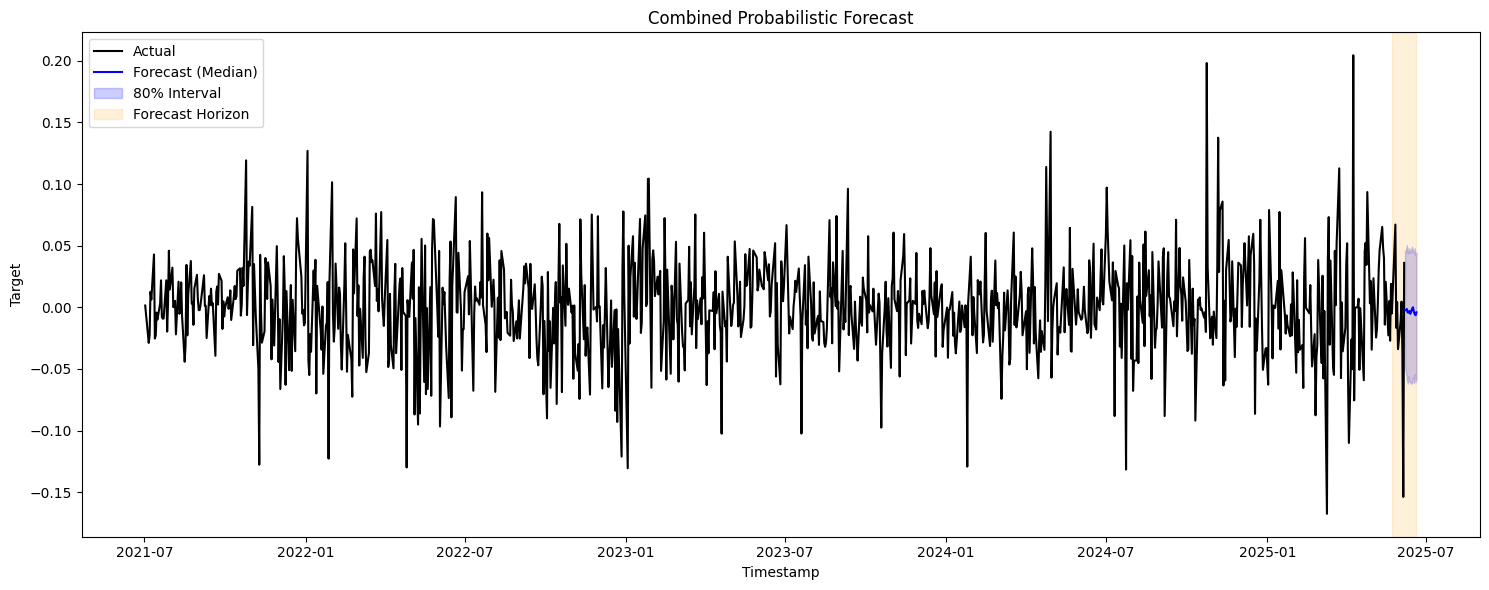

In [99]:
plot_combined_forecast_wide(exo_train_ds, pred, prediction_length)


## Common Time Series Pitfalls (and How to Avoid Them)

⚠️ **Leakage from the future**  
Using information that was not available at the forecast origin (e.g. using future values of features as "past" covariates).  
✅ Always construct features using only data up to time *t* when predicting time *t+1, t+2, …*.

⚠️ **Over-differencing the target**  
Differencing multiple times until the series "looks flat" can destroy useful structure.  
✅ Use tests (ADF/KPSS) and domain knowledge; stop once residuals look approximately stationary.

⚠️ **Ignoring evaluation design**  
A random train/test split breaks temporal dependence and gives over-optimistic metrics.  
✅ Use **rolling / expanding windows** and keep test windows strictly in the future relative to training windows.

⚠️ **Judging models by a single metric**  
Different metrics can rank models differently, especially with skewed scales or outliers.  
✅ Track at least one **scale-dependent** (e.g. RMSE) and one **scale-free** metric (e.g. sMAPE/MASE).

⚠️ **Treating forecasts as facts**  
Forecasts are distributions over possible futures, not certainties.  
✅ Use prediction intervals, run scenario analyses, and combine model output with domain intuition and business judgment.


### Autogluon Log/Notes

| **#**  | **Issue / Gotcha**                                            | **Description**                                                                   | **Impact**                                       | **Fix / Recommendation**                                                          |
| ------ | ------------------------------------------------------------- | --------------------------------------------------------------------------------- | ------------------------------------------------ | --------------------------------------------------------------------------------- |
| **1**  | **ARIMA disabled on Python ≥ 3.12**                           | `statsmodels` not supported in Python 3.12+                                       | ARIMA, AutoARIMA, ETS, Theta silently removed    | Use Python 3.10/3.11 or avoid statsmodels models                                  |
| **2**  | **`presets="fast_training"` disables advanced models**        | Fast preset removes DeepAR, Chronos, TFT, PatchTST, Tabular                       | Only Naive/Seasonal/Theta remain                 | Use `"medium_quality"` or specify `hyperparameters={}`                            |
| **3**  | **`known_covariates_names` disables incompatible models**     | Models not supporting future-known-covariates removed                             | ARIMA/ETS/Theta/NPTS/DLinear ignored             | Ensure your pool includes covariate-aware models (DeepAR, Chronos, TFT, PatchTST) |
| **4**  | **Feature importance returns all zeros**                      | Endogenous-only models trained, or features added *after* fit, or schema mismatch | All features show importance = 0                 | Add engineered features *before* fit; ensure exogenous models included            |
| **5**  | **DeepAR not trained unless explicitly requested**            | Medium-quality preset prioritizes Chronos and stops early                         | DeepAR never attempted                           | Specify `hyperparameters={"DeepAR": {}, "Chronos": {}}`                           |
| **6**  | **Frequency “IRREG” triggers invisible resampling**           | Irregular timestamps → AG resamples to “D” automatically                          | Creates NaNs, distorts patterns                  | Manually resample and inspect data before training                                |
| **7**  | **Missing item_id collapses model to 1 series**               | Without item_id, AG assumes single series                                         | DeepAR/TFT degrade severely                      | Always define item_id (synthetic if needed)                                       |
| **8**  | **Model exclusions override hyperparameters silently**        | A model present in both hyperparameters and excluded list is removed              | Model never trains, no error                     | Clean up `excluded_model_types`; be explicit                                      |
| **9**  | **MAPE returns negative values**                              | AG flips sign for “higher-is-better”                                              | Confusing metrics like -2.21                     | Report using `abs(mape)`                                                          |
| **10** | **Backtesting windows misunderstood**                         | `num_val_windows` (training CV) ≠ manual evaluate windows                         | Wrong interpretation of validation vs evaluation | Keep them separate; evaluate using manual cutoff windows                          |
| **11** | **Models requiring covariates fail if future values missing** | Known features must exist for entire forecast horizon                             | Models drop covariates silently                  | Always generate future-known covariates for prediction_length                     |
| **12** | **Short time_limit skips other models**                       | Chronos trains quickly → AG stops early                                           | Only 1 model trained                             | Increase `time_limit` or explicitly specify all desired models                    |
